# Data extraction and processing

In [1]:
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
mnist = fetch_openml('mnist_784')
required_target = mnist.target.reshape(len(mnist.target), 1)
a = OneHotEncoder()
a.fit(required_target)
inputData = mnist.data 
target = a.transform(required_target).toarray()

In [2]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(inputData, target)

# Plotting the images

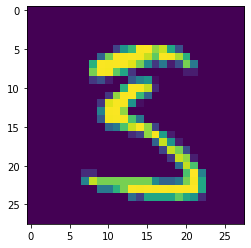

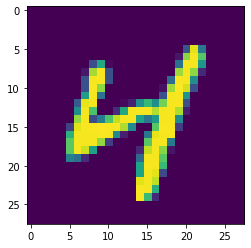

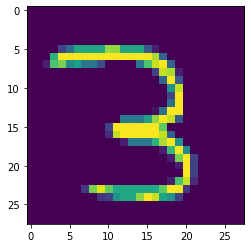

In [3]:
import matplotlib.pyplot as plt
img1 = x_train[10].reshape((28, 28))
img2 = x_train[5].reshape((28, 28))
img3 = x_train[489].reshape((28, 28))
plt.imshow(img1)
plt.show()
plt.imshow(img2)
plt.show()
plt.imshow(img3)
plt.show()

In [4]:
input_width = 28
input_height = 28
input_channels = 1
input_pixeles = 784

n_conv1 = 32
n_conv2 = 64
stride_conv1 = 1
stride_conv2 = 1
conv1_k = 5
conv2_k = 5
pool1_k = 2
pool2_k = 2

n_hidden = 1024
n_output = 10

hidden_input_size = (input_width//(pool1_k * pool2_k)) * (input_height//(pool1_k * pool2_k)) * n_conv2

In [5]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

weights = {
    "weightsConv1" : tf.Variable(tf.random_normal([conv1_k, conv1_k, input_channels, n_conv1])),
    "weightsConv2" : tf.Variable(tf.random_normal([conv2_k, conv2_k, n_conv1, n_conv2])),
    "weightsHidden" : tf.Variable(tf.random_normal([hidden_input_size, n_hidden])),
    "weightsOutput" : tf.Variable(tf.random_normal([n_hidden, n_output]))
}

biases = {
    "biasConv1" : tf.Variable(tf.random_normal([n_conv1])),
    "biasConv2" : tf.Variable(tf.random_normal([n_conv2])),
    "biasHidden" : tf.Variable(tf.random_normal([n_hidden])),
    "biasOutput" : tf.Variable(tf.random_normal([n_output]))
}

Instructions for updating:
non-resource variables are not supported in the long term


In [6]:
def convolution(x, weights, bias, stride = 1):
    out = tf.nn.conv2d(x, weights, padding = "SAME", strides = [1, stride, stride, 1])
    out = tf.nn.bias_add(out, bias)
    out = tf.nn.relu(out)
    
    return out

In [7]:
def maxPooling(x, k = 2):
    return tf.nn.max_pool(x, padding = "SAME", ksize = [1, k, k, 1], strides = [1, k, k, 1])

In [8]:
def cnn(x, weights, biases, keep_probability):
    x = tf.reshape(x, shape = [-1, input_height, input_width, input_channels])
    
    # convolution layer 1
    conv1Out = convolution(x, weights['weightsConv1'], biases['biasConv1'], stride_conv1)
    conv1Pool = maxPooling(conv1Out, pool1_k)
    
    # convolution layer 2
    conv2Out = convolution(conv1Pool, weights['weightsConv2'], biases['biasConv2'], stride_conv2)
    conv2Pool = maxPooling(conv2Out, pool2_k)
    
    # hidden layer
    hiddenInput = tf.reshape(conv2Pool, shape = [-1, hidden_input_size])
    hiddenOutput_before_activation = tf.add(tf.matmul(hiddenInput, weights['weightsHidden']), biases['biasHidden'])
    hiddenOutput_before_dropout = tf.nn.relu(hiddenOutput_before_activation)
    
    # applying regularization - dropout layer
    hiddenOutput = tf.nn.dropout(hiddenOutput_before_dropout, keep_probability)
    
    # output layer
    output = tf.add(tf.matmul(hiddenOutput, weights['weightsOutput']), biases['biasOutput'])
    
    return output

In [9]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

x = tf.placeholder("float", [None, input_pixeles])
y = tf.placeholder(tf.int32, [None, n_output])
keep_prob = tf.placeholder("float")
pred = cnn(x, weights, biases, keep_prob)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = pred, labels = y))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Optimization

In [10]:
# optimization
optimizer = tf.train.AdamOptimizer(learning_rate = 0.05)
optimize = optimizer.minimize(cost)

In [11]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

batch_size = 500
c = 0
sess.run(tf.global_variables_initializer())
for i in range(10):
    for s in range(0, x_train.shape[0], batch_size):
        batch_x = x_train[s : (s + batch_size)]
        batch_y = y_train[s : (s + batch_size)]
        c, _ = sess.run([cost, optimize], feed_dict = {x: batch_x, y: batch_y, keep_prob: 0.8})
    print(c, end = " , ")

1323.5402 , 145.69463 , 72.44468 , 35.315845 , 29.03098 , 15.326649 , 12.51436 , 8.205829 , 5.067937 , 7.356382 , 

In [19]:
Predictions = tf.argmax(pred, axis = 1)
correct_labels = tf.argmax(y, axis = 1)
y_pred, true_labels = sess.run([Predictions, correct_labels], 
                                             feed_dict = {x: x_test, y: y_test, keep_prob : 0.8})

correct_predictions = tf.equal(y_pred, true_labels)

correct_pred = sess.run(correct_predictions, feed_dict = {x: x_test, y: y_test})

print("Correctly predicted classes :", correct_pred.sum(), " among ", x_test.shape[0])
print("\n\nAccuracy : ", accuracy_score(y_pred, true_labels) * 100)
print("\n\n\n Classification Report : \n\n\n", classification_report(y_pred, true_labels))

Correctly predicted classes : 2076  among  17500


Accuracy :  11.862857142857143



 Classification Report : 


               precision    recall  f1-score   support

           0       0.00      0.25      0.00         8
           1       1.00      0.12      0.21     17382
           2       0.00      0.36      0.01        14
           3       0.00      0.14      0.00         7
           4       0.00      0.40      0.00        10
           5       0.00      0.33      0.01        15
           6       0.00      0.11      0.00         9
           7       0.01      0.70      0.03        37
           8       0.00      0.20      0.00         5
           9       0.00      0.23      0.00        13

    accuracy                           0.12     17500
   macro avg       0.10      0.28      0.03     17500
weighted avg       0.99      0.12      0.21     17500



In [ ]:
accuracy_score(predictions, correct_pred)